This is the second part in a series of notes on my exploration of the recently released [Google QuickDraw dataset](https://quickdraw.withgoogle.com/data), using the concurrently released [SketchRNN model][Ha2017]. 

In the [previous note](../exploring-the-google-quickdraw-dataset-with-sketchrnn-part-1/), we set up our development environment, downloaded a subset of the data along with some pre-trained models, and developed some utilities for visualizing the data in the notebook.

We retain most of the code from previous note and omit the detailed explanations.

---

The QuickDraw dataset is curated from the millions of drawings contributed by over 15 million people around the world who participated in the ["Quick, Draw!" A.I. Experiment](https://aiexperiments.withgoogle.com/quick-draw), in which they were given the challenge of drawing objects belonging to a particular class (such as "cat") in under 20 seconds.

SketchRNN is a very impressive generative model that was trained to produce vector drawings using this dataset. It was of particular interest to me because it cleverly combines many of the latest tools and techniques recently developed in machine learning, such as [Variational Autoencoders][Kingma2013], HyperLSTMs (a [HyperNetwork][Ha2016] for LSTM), [Autoregressive models][Reed2017], [Layer Normalization][Ba2016], [Recurrent Dropout][Semeniuta2016], the [Adam optimizer][Kingma2014], and others.

[Ha2017]: http://arxiv.org/abs/1704.03477 "D. Ha and D. Eck, 'A Neural Representation of Sketch Drawings,' Apr. 2017."
[Ha2016]: https://arxiv.org/abs/1609.09106 "D. Ha, A. Dai, and Q. V. Le, 'HyperNetworks,' Sep. 2016."
[Kingma2013]: https://arxiv.org/abs/1312.6114 "D. P. Kingma and M. Welling, 'Auto-Encoding Variational Bayes,' Dec. 2013."
[Reed2017]: https://arxiv.org/abs/1703.03664 "S. Reed et al., 'Parallel Multiscale Autoregressive Density Estimation,' Mar. 2017."
[Semeniuta2016]: https://arxiv.org/abs/1603.05118 "S. Semeniuta, A. Severyn, and E. Barth, 'Recurrent Dropout without Memory Loss,' Mar. 2016."
[Ba2016]: https://arxiv.org/abs/1607.06450 "J. L. Ba, J. R. Kiros, and G. E. Hinton, 'Layer Normalization,' Jul. 2016."
[Kingma2014]: https://arxiv.org/abs/1412.6980 "D. P. Kingma and J. Ba, 'Adam: A Method for Stochastic Optimization,' Dec. 2014."

### Environment Set-up

Some preamble for plotting (I really ought to put these in a config file at some point...), and importing dependencies. I've made the imports here explicit so we know exactly what methods/objects are imported and can find the module from which they were imported more easily.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
%load_ext autoreload
%autoreload 2

In [330]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import numpy as np
import tensorflow as tf

from six.moves import map
from matplotlib.path import Path

In [299]:
from magenta.models.sketch_rnn.sketch_rnn_train import \
    (load_env,
     load_checkpoint,
     reset_graph,
     download_pretrained_models,
     PRETRAINED_MODELS_URL)
from magenta.models.sketch_rnn.model import Model, sample
from magenta.models.sketch_rnn.utils import (lerp,
                                             slerp,
                                             get_bounds, 
                                             to_big_strokes,
                                             to_normal_strokes)

In [8]:
# set numpy output to something sensible
np.set_printoptions(precision=8, 
                    edgeitems=6, 
                    linewidth=200, 
                    suppress=True)

In [9]:
tf.logging.info("TensorFlow Version: {}".format(tf.__version__))

INFO:tensorflow:TensorFlow Version: 1.1.0


### Getting the Pre-Trained Models and Data

In [10]:
DATA_DIR = ('http://github.com/hardmaru/sketch-rnn-datasets/'
            'raw/master/aaron_sheep/')
MODELS_ROOT_DIR = '/tmp/sketch_rnn/models'

In [11]:
DATA_DIR

'http://github.com/hardmaru/sketch-rnn-datasets/raw/master/aaron_sheep/'

In [12]:
PRETRAINED_MODELS_URL

'http://download.magenta.tensorflow.org/models/sketch_rnn.zip'

In [13]:
download_pretrained_models(
    models_root_dir=MODELS_ROOT_DIR,
    pretrained_models_url=PRETRAINED_MODELS_URL)

INFO:tensorflow:/tmp/sketch_rnn/models/sketch_rnn.zip already exists, using cached copy
INFO:tensorflow:Unzipping /tmp/sketch_rnn/models/sketch_rnn.zip...
INFO:tensorflow:Unzipping complete.


We look at the layer normalized model trained on the `aaron_sheep` dataset for now.

In [15]:
MODEL_DIR = MODELS_ROOT_DIR + '/aaron_sheep/layer_norm'

In [16]:
(train_set, 
 valid_set, 
 test_set, 
 hps_model, 
 eval_hps_model, 
 sample_hps_model) = load_env(DATA_DIR, MODEL_DIR)

INFO:tensorflow:Downloading http://github.com/hardmaru/sketch-rnn-datasets/raw/master/aaron_sheep/aaron_sheep.npz
INFO:tensorflow:Loaded 7400/300/300 from aaron_sheep.npz
INFO:tensorflow:Dataset combined: 8000 (7400/300/300), avg len 125
INFO:tensorflow:model_params.max_seq_len 250.
total images <= max_seq_len is 7400
total images <= max_seq_len is 300
total images <= max_seq_len is 300
INFO:tensorflow:normalizing_scale_factor 18.5198.


In [201]:
class StrokesPath(Path):
    
    def __init__(self, data, factor=.2, *args, **kwargs):
        
        vertices = np.cumsum(data[::, :-1], axis=0) / factor
        codes = np.roll(self.to_code(data[::,-1].astype(int)), 
                        shift=1)
        codes[0] = Path.MOVETO
        
        super(StrokesPath, self).__init__(vertices, 
                                          codes, 
                                          *args, 
                                          **kwargs)
        
    @staticmethod
    def to_code(cmd):
        # if cmd == 0, the code is LINETO
        # if cmd == 1, the code is MOVETO (which is LINETO - 1)
        return Path.LINETO - cmd

In [202]:
def draw(stroke, factor=.2, pad=(10, 10), ax=None):

    if ax is None:
        ax = plt.gca()

    x_pad, y_pad = pad
    
    x_pad //= 2
    y_pad //= 2
        
    x_min, x_max, y_min, y_max = get_bounds(data=stroke,
                                            factor=factor)

    ax.set_xlim(x_min-x_pad, x_max+x_pad)
    ax.set_ylim(y_max+y_pad, y_min-y_pad)

    strokes = StrokesPath(stroke)

    patch = patches.PathPatch(strokes, facecolor='none')
    ax.add_patch(patch)

In [28]:
# construct the sketch-rnn model here:
reset_graph()
model = Model(hps_model)
eval_model = Model(eval_hps_model, reuse=True)
sample_model = Model(sample_hps_model, reuse=True)

INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = False.
INFO:tensorflow:Output dropout mode = False.
INFO:tensorflow:Recurrent dropout mode = True.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = False.
INFO:tensorflow:Output dropout mode = False.
INFO:tensorflow:Recurrent dropout mode = False.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = False.
INFO:tensorflow:Output dropout mode = False.
INFO:tensorflow:Recurrent dropout mode = False.


In [281]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [282]:
# loads the weights from checkpoint into our model
load_checkpoint(sess=sess, checkpoint_path=MODEL_DIR)

INFO:tensorflow:Loading model /tmp/sketch_rnn/models/aaron_sheep/layer_norm/vector.
INFO:tensorflow:Restoring parameters from /tmp/sketch_rnn/models/aaron_sheep/layer_norm/vector


In [283]:
def encode(input_strokes):
    strokes = to_big_strokes(input_strokes).tolist()
    strokes.insert(0, [0, 0, 1, 0, 0])
    seq_len = [len(input_strokes)]
    z = sess.run(eval_model.batch_z,
                 feed_dict={
                    eval_model.input_data: [strokes], 
                    eval_model.sequence_lengths: seq_len})[0]
    return z

In [284]:
def decode(z_input=None, temperature=.1, factor=.2):
    z = None
    if z_input is not None:
        z = [z_input]
    sample_strokes, m = sample(sess, 
                               sample_model, 
                               seq_len=eval_model.hps.max_seq_len, 
                               temperature=temperature, z=z)
    return to_normal_strokes(sample_strokes)

In [290]:
a = test_set.random_sample()

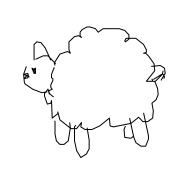

In [291]:
fig, ax = plt.subplots(figsize=(3, 3),
                       subplot_kw=dict(xticks=[], yticks=[], frame_on=False))

draw(a, ax=ax)

plt.show()

In [305]:
z = encode(a)

In [306]:
z.shape

(128,)

In [307]:
b = decode(z, temperature=0.6)

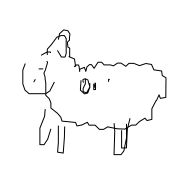

In [309]:
fig, ax = plt.subplots(figsize=(3, 3),
                       subplot_kw=dict(xticks=[], yticks=[], frame_on=False))

draw(b, ax=ax)

plt.show()

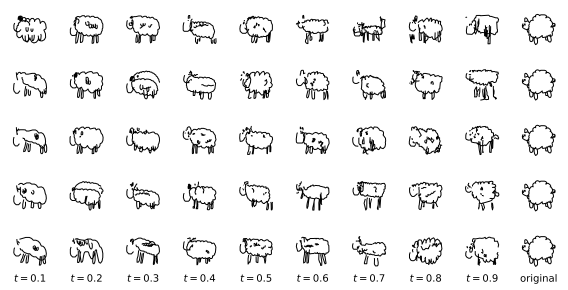

In [296]:
fig, ax_arr = plt.subplots(nrows=5, 
                           ncols=10, 
                           figsize=(8, 4),
                           subplot_kw=dict(xticks=[],
                                           yticks=[],
                                           frame_on=False))
fig.tight_layout()

for row_num, ax_row in enumerate(ax_arr):    
    for col_num, ax in enumerate(ax_row):
        if col_num+1 == len(ax_row):
            draw(a, ax=ax)
            xlabel = 'original'
        else:
            t = .1*(col_num+1)
            draw(decode(z, temperature=t), ax=ax)
            xlabel = '$t={}$'.format(t)
        if row_num+1 == len(ax_arr):
            ax.set_xlabel(xlabel)

plt.show()

#### Interactivity / Animation

### Linear Interpolation

In [298]:
np.linspace(0, 1, 10)

array([ 0.        ,  0.11111111,  0.22222222,  0.33333333,  0.44444444,  0.55555556,  0.66666667,  0.77777778,  0.88888889,  1.        ])

In [311]:
lerp(0., 1., np.linspace(0, 1, 10))

array([ 0.        ,  0.11111111,  0.22222222,  0.33333333,  0.44444444,  0.55555556,  0.66666667,  0.77777778,  0.88888889,  1.        ])

In [320]:
slerp(-np.pi, 0.5, np.linspace(0, 1, 10))

array([ -3.14159265e+00,  -7.37745690e+15,  -1.38650836e+16,  -1.86803766e+16,  -2.12425405e+16,  -2.12425405e+16,  -1.86803766e+16,  -1.38650836e+16,  -7.37745690e+15,   5.00000000e-01])

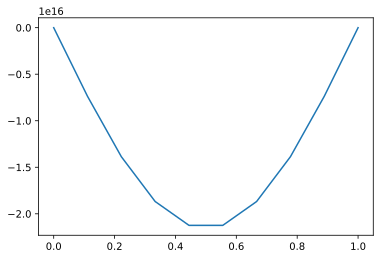

In [322]:
fig, ax = plt.subplots()

ax.plot(np.linspace(0, 1, 10),
        slerp(-np.pi, 0.5, np.linspace(0, 1, 10)))

plt.show()

### PCA

In [459]:
Z = np.vstack(map(encode, test_set.strokes[::1]))
Z.shape

(300, 128)

In [460]:
from sklearn.decomposition import PCA

In [461]:
pca = PCA(n_components=2)

In [462]:
pca.fit(Z)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [463]:
pca.explained_variance_ratio_

array([ 0.02185169,  0.02119012])

In [464]:
Z_pca = pca.transform(Z)

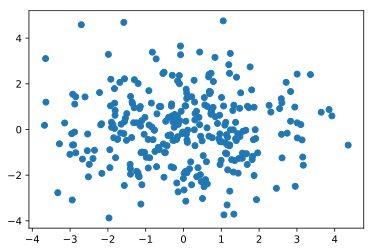

In [465]:
fig, ax = plt.subplots()

ax.scatter(*Z_pca.T)

plt.show()

In [466]:
x_min, y_min = np.amin(Z_pca, axis=0)
x_max, y_max = np.amax(Z_pca, axis=0)

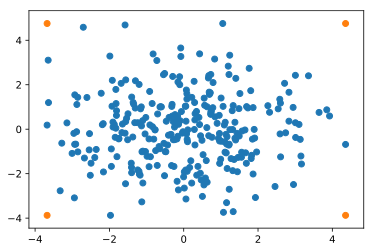

In [467]:
fig, ax = plt.subplots()

ax.scatter(*Z_pca.T)

ax.scatter([x_min, x_min, x_max, x_max], [y_min, y_max, y_min, y_max])

plt.show()

In [468]:
x = lerp(x_min, x_max, np.linspace(0, 1, 10))

In [469]:
y = lerp(y_min, y_max, np.linspace(0, 1, 10))

In [470]:
xx, yy = np.meshgrid(x, y)

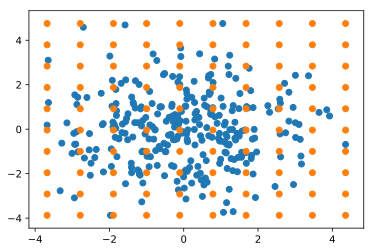

In [471]:
fig, ax = plt.subplots()

ax.scatter(*Z_pca.T)

# ax.scatter([x_min, x_min, x_max, x_max], [y_min, y_max, y_min, y_max])
ax.scatter(xx, yy)

plt.show()

In [472]:
np.dstack((xx, yy)).shape

(10, 10, 2)

In [473]:
z_grid = np.apply_along_axis(pca.inverse_transform,  
                             arr=np.dstack((xx, yy)),
                             axis=2)
z_grid.shape

(10, 10, 128)

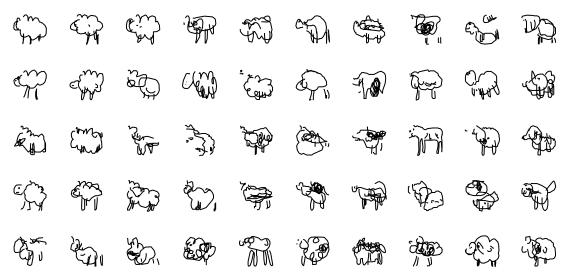

In [474]:
fig, ax_arr = plt.subplots(nrows=5, 
                           ncols=10, 
                           figsize=(8, 4),
                           subplot_kw=dict(xticks=[],
                                           yticks=[],
                                           frame_on=False))
fig.tight_layout()

for row_num, ax_row in enumerate(ax_arr):    
    for col_num, ax in enumerate(ax_row):
        draw(decode(z_grid[row_num, col_num], temperature=.5), ax=ax)
        ax.axis('off')

plt.show()

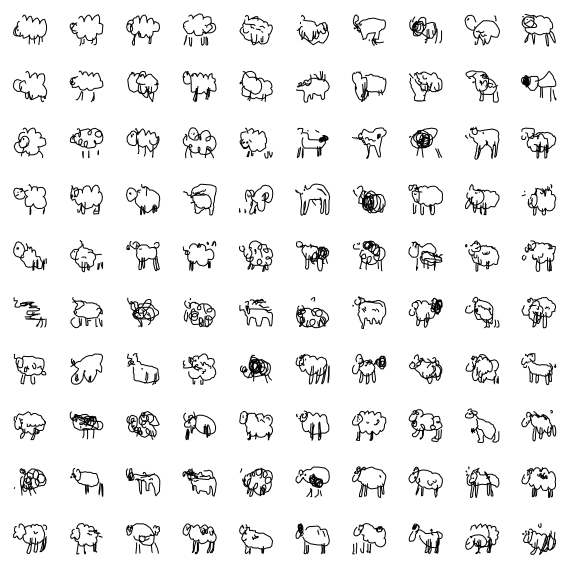

In [488]:
fig, ax_arr = plt.subplots(nrows=10, 
                           ncols=10, 
                           figsize=(8, 8),
                           subplot_kw=dict(xticks=[],
                                           yticks=[],
                                           frame_on=False))
fig.tight_layout()

for row_num, ax_row in enumerate(ax_arr):    
    for col_num, ax in enumerate(ax_row):
        draw(decode(z_grid[row_num, col_num], temperature=.5), ax=ax)
        ax.axis('off')

plt.show()

### What do you call a baby eigensheep? A lamb, duh.

In [364]:
z_pc1, z_pc2 = pca.components_

In [489]:
pca.explained_variance_

array([ 2.54362871,  2.46661948])

In [503]:
np.dot(Z, z_pc1).shape

(300,)

In [367]:
z_pc1.shape

(128,)

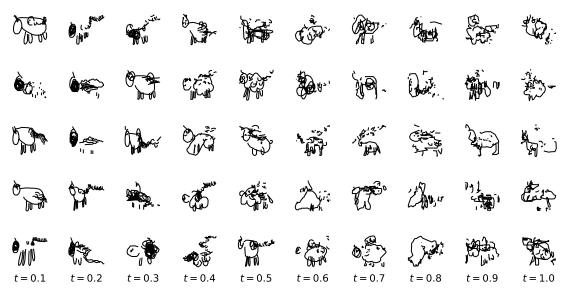

In [370]:
fig, ax_arr = plt.subplots(nrows=5, 
                           ncols=10, 
                           figsize=(8, 4),
                           subplot_kw=dict(xticks=[],
                                           yticks=[],
                                           frame_on=False))
fig.tight_layout()

for row_num, ax_row in enumerate(ax_arr):    
    for col_num, ax in enumerate(ax_row):
        t = .1*(col_num+1)
        draw(decode(z_pc1, temperature=t), ax=ax)

        if row_num+1 == len(ax_arr):
            ax.set_xlabel('$t={}$'.format(t))
        
plt.show()

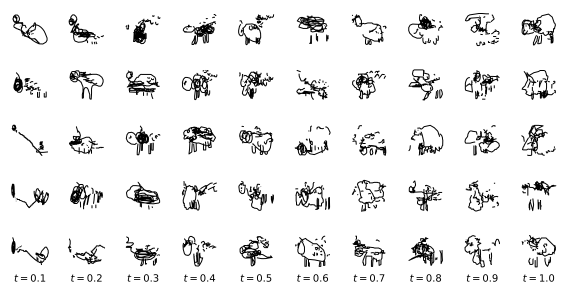

In [375]:
fig, ax_arr = plt.subplots(nrows=5, 
                           ncols=10, 
                           figsize=(8, 4),
                           subplot_kw=dict(xticks=[],
                                           yticks=[],
                                           frame_on=False))
fig.tight_layout()

for row_num, ax_row in enumerate(ax_arr):    
    for col_num, ax in enumerate(ax_row):
        t = .1*(col_num+1)
        draw(decode(z_pc2, temperature=t), ax=ax)

        if row_num+1 == len(ax_arr):
            ax.set_xlabel('$t={}$'.format(t))
        
plt.show()

In [377]:
pca.transform(Z)[0]

array([ 4.34574302,  5.33103427])

In [379]:
pca.transform(Z[0, None])

array([[ 4.34574302,  5.33103427]])

In [383]:
pca.inverse_transform(np.array([1, 1]))

array([-0.02939586, -0.28331373,  0.04465353,  0.02473021,  0.00627115,  0.10955197, -0.0007027 , -0.24404268,  0.0417807 ,  0.19916986,  0.13403476,  0.16840006,  0.06493378,  0.24039761,
        0.08608112,  0.05069234, -0.01937626, -0.00453535, -0.13843334, -0.03956904,  0.11845299,  0.32183622,  0.55874877, -0.12477545,  0.6663206 ,  0.09780656, -0.20613144, -0.86738774,
        0.00139719,  0.13452641,  0.07592542, -0.32897006, -0.21971871,  0.32780255,  0.07357785, -0.30654494, -0.62118113,  0.43549604,  0.32440967,  0.1266    , -0.41316433,  0.18937799,
       -0.02568606,  0.12334598,  0.15669325,  0.11818755, -0.14828127, -0.41572751,  0.00052259,  0.01955933, -0.0544879 , -0.54378989,  0.11888979,  0.07030514,  0.35669118, -0.048812  ,
        0.08433363, -0.11297859, -0.19714181, -0.24151172,  0.22331174, -0.08905018,  0.1149186 ,  0.12806576,  0.00193005,  0.21291777, -0.49790171, -0.06428931,  0.18669963,  0.05598358,
       -0.30918922, -0.00268387,  0.21184086,  0.333798

In [475]:
from sklearn.manifold import TSNE

In [485]:
tsne = TSNE(n_components=2, n_iter=5000)

In [486]:
Z_tsne = tsne.fit_transform(Z)

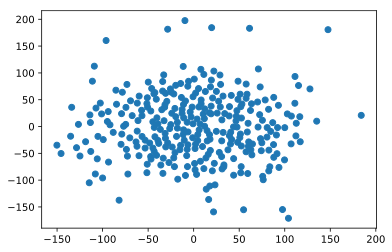

In [487]:
fig, ax = plt.subplots()

ax.scatter(*Z_tsne.T)

plt.show()